In [2]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [3]:
file="dataset/whatsapp.txt"
key="12hr"
split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

In [4]:
with open(file, 'r', encoding='utf-8') as raw_data:
    raw_string = ' '.join(raw_data.read().split('\n')) 
    user_msg = re.split(split_formats[key], raw_string) [1:] 
    date_time = re.findall(split_formats[key], raw_string) 
    df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg})

In [5]:
df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
usernames = []
msgs = []
for i in df['user_msg']:
    a = re.split('([\w\W]+?):\s', i)
    if(a[1:]):
        usernames.append(a[1])
        msgs.append(a[2])
    else:
        usernames.append("group_notification")
        msgs.append(a[0])   
df['user'] = usernames
df['message'] = msgs
df.drop('user_msg', axis=1, inplace=True)

In [6]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())
df1 = df.copy()
df1['message_count'] = [1] * df1.shape[0]
df1.drop(columns='year', inplace=True)
df1 = df1.groupby('date').sum().reset_index()
df1.head()

,date,message_count
0,2020-01-24,1
1,2020-01-26,105
2,2020-01-27,90
3,2020-01-28,126
4,2020-01-29,118


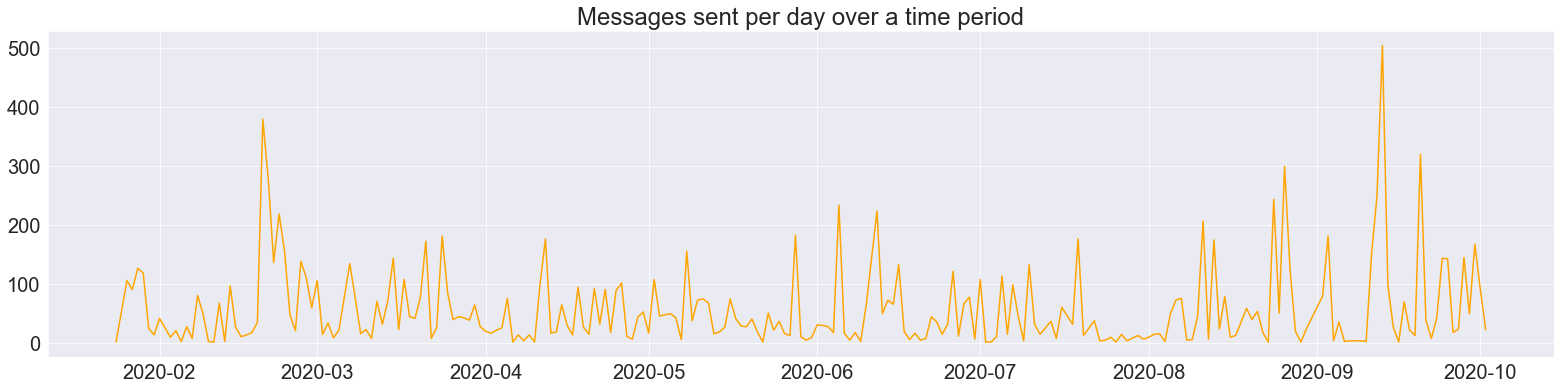

In [7]:
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)
plt.plot(df1.date, df1.message_count,color="orange")
plt.title('Messages sent per day over a time period');

In [8]:
top5days = df1.sort_values(by="message_count", ascending=False).head(5)
top5days.reset_index(inplace=True)
top5days.drop(columns="index", inplace=True)
top5days

,date,message_count
0,2020-09-13,504
1,2020-02-20,379
2,2020-09-20,319
3,2020-08-26,299
4,2020-02-21,278


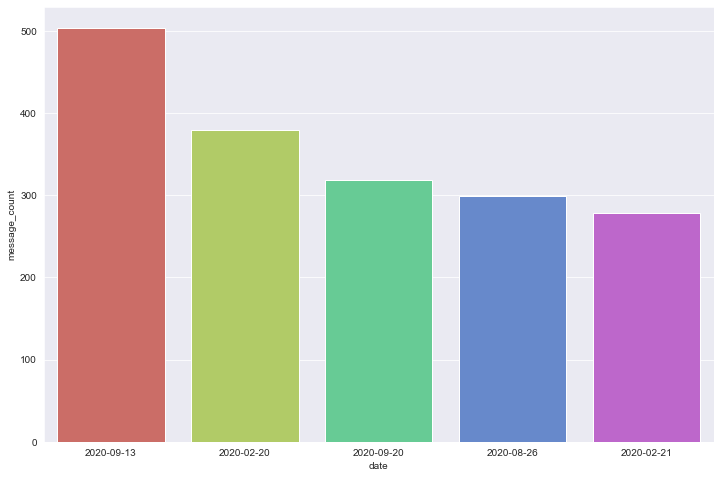

In [18]:
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.barplot(top5days.date, top5days.message_count, palette="hls");
plt.savefig('top5_days.svg', format = 'svg')

In [ ]:
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")
print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

In [10]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


In [11]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
top10df.initials[7] = "Me"
top10df.initials[8] = "DT"

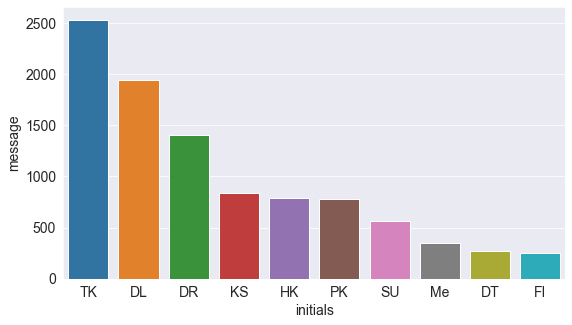

In [13]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.barplot(top10df.initials, top10df.message, data=top10df);

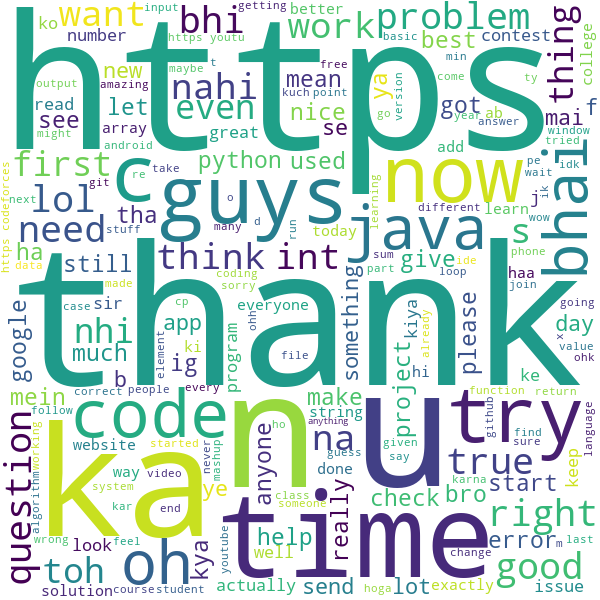

In [16]:
comment_words = ' '
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])
for val in df2.message.values:
    val = str(val) 
    tokens = val.split()
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words)
wordcloud.to_image()